# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [14]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier

from utils import datasets, train_and_eval_model, run_hparam_search


#### Processing the data

In [15]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')
print(bc_data.head())

# Handle NaN values

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

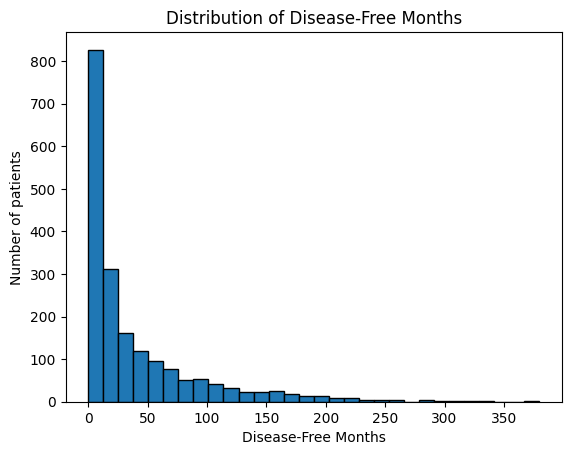

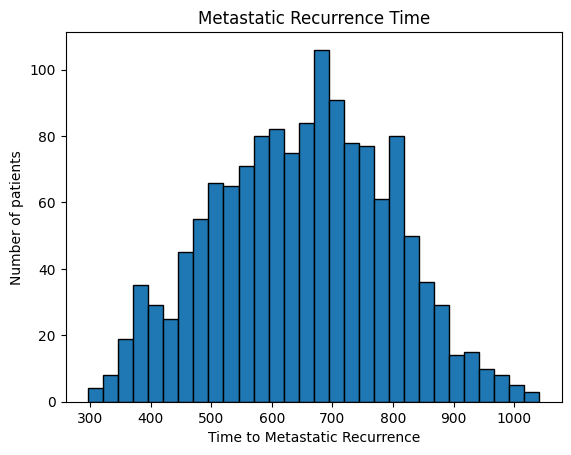

In [16]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()

In [66]:
# Split data into train, valid, test sets

train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [67]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )

#### Training a logistic regression model

In [60]:
# Code to train logistic regression model

#### Evaluating the logistic regression model

In [61]:
# Code to train logistic regression model

#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

Metrics: {'train': 0.45185138266888114, 'valid': 84.50406229503086, 'test': 77.96352997159991}


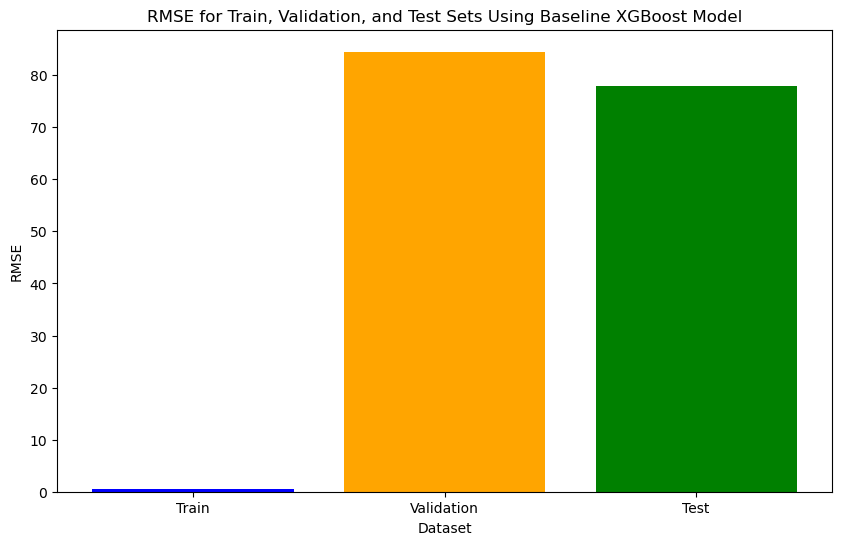

In [75]:
# Handle categorical features
categorical_features = ds_instance.train_X.select_dtypes(include=["object"]).columns

for col in categorical_features:
    ds_instance.train_X[col] = ds_instance.train_X[col].astype("category")
    ds_instance.valid_X[col] = ds_instance.valid_X[col].astype("category")
    ds_instance.test_X[col] = ds_instance.test_X[col].astype("category")

# Define XGBoost model
XGB_model = XGBRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)

# Define features to include
features_to_include = ["Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
                       "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
                       "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
                       "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
                       "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
                       "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
                       "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
                       "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", "Overall Survival Status", 
                       "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
                       "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
                       "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
                       "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
                       "Time To Death (Months)", "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin", "Patient's Vital Status"]

# Remove rows with NaN values in the features to include
ds_instance.train_X = ds_instance.train_X[features_to_include].dropna()
ds_instance.valid_X = ds_instance.valid_X[features_to_include].dropna()
ds_instance.test_X = ds_instance.test_X[features_to_include].dropna()

# Ensure the target variable has no NaN values
ds_instance.train_y = ds_instance.train_y[ds_instance.train_X.index]
ds_instance.valid_y = ds_instance.valid_y[ds_instance.valid_X.index]
ds_instance.test_y = ds_instance.test_y[ds_instance.test_X.index]

# Train and evaluate XGBoost model
predictions, metrics = train_and_eval_model(model=XGB_model, ds=ds_instance, features_to_include=features_to_include)

# Report metrics
print("Metrics:", metrics)

# Plot metrics
# Extract the metrics
train_rmse = metrics['train']
valid_rmse = metrics['valid']
test_rmse = metrics['test']

# Create a bar plot
labels = ['Train', 'Validation', 'Test']
rmse_values = [train_rmse, valid_rmse, test_rmse]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Train, Validation, and Test Sets Using Baseline XGBoost Model')
plt.show()

#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [80]:
# Remove categorical features from the dataset (TODO: figure out how to handle categorical features)
ds_instance.train_X = ds_instance.train_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.valid_X = ds_instance.valid_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.test_X = ds_instance.test_X.select_dtypes(include=["int", "float", "bool"])

# Update features_to_include to only include numerical features
features_to_include = ds_instance.train_X.columns.tolist()

print(len(features_to_include))

# Run a hyperparameter search
best_metrics, best_params = run_hparam_search(ds=ds_instance, features_to_include=features_to_include)

# Report best hyperparameters and model performance
print("Best Hyperparameters Found:", best_params)
print("Best Metrics Found:", best_metrics)


12
Best Hyperparameters Found: {'max_depth': 1, 'learning_rate': 0.3, 'n_estimators': 50}
Best Metrics Found: {'train': 6.270194468470398, 'valid': 58.119384753422494, 'test': 90.42624386529701}


#### Training a Random Survival Forest Model


Concordance index: 0.882


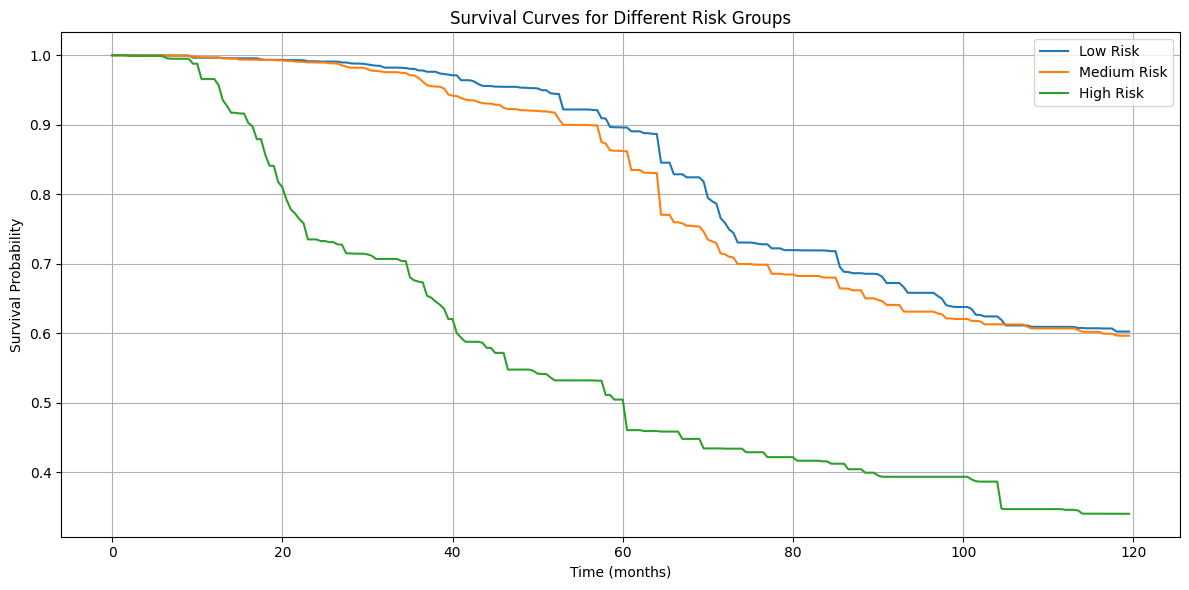

Cross-validation concordance index: 0.865 ± 0.010


In [19]:
#### Training a Random Survival Forest Model for Survival Prediction

# Define features to include (same as before)
features_to_include = [
    "Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
    "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
    "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
    "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
    "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
    "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
    "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
    "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", 
    "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
    "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
    "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
    "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
    "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin"
]

# 1. Load the data
data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')

# 2. Prepare the survival outcome
# For overall survival prediction:
#   - Time: "Overall Survival (Months)"
#   - Event: "Overall Survival Status" (1/True if deceased, 0/False if alive)
y = np.array(
    [(str(status).strip().lower() == "deceased", float(time))
     for status, time in zip(data["Patient's Vital Status"], data["Overall Survival (Months)"])],
    dtype=[("event", "bool"), ("time", "float")]
)

# 3. Filter out rows with missing survival data
valid_indices = ~np.isnan(data["Overall Survival (Months)"])
y = y[valid_indices]
data = data.loc[valid_indices]

# 4. Prepare the feature matrix using the specified features
X = data[features_to_include]

# 5. Convert categorical features to numerical representations
# One-hot encode non-numeric columns
X = pd.get_dummies(X, drop_first=True)

# 6. Handle missing values by filling with median for numeric columns
X = X.fillna(X.median())

# 7. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build and train the Random Survival Forest model
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

# 9. Evaluate the model on the test set using the concordance index
c_index = concordance_index_censored(y_test["event"], y_test["time"], rsf.predict(X_test))
print(f"Concordance index: {c_index[0]:.3f}")

# Note: Feature importance calculation is not supported in this version of scikit-survival
# Skipping feature importance visualization

# 12. Estimate and plot survival curves for different risk groups
test_pred = rsf.predict(X_test)
# Convert to pandas Series first so we can use qcut
risk_scores = pd.Series(test_pred)
risk_groups = pd.qcut(risk_scores, 3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Setup figure
plt.figure(figsize=(12, 6))

# Get survival curves for each risk group
times = np.arange(0, 120, 0.5)  # 0 to 10 years in months

for risk_group in ['Low Risk', 'Medium Risk', 'High Risk']:
    # Get indices of patients in this risk group
    indices = np.where(risk_groups == risk_group)[0]
    
    if len(indices) > 0:  # Make sure there are samples in this group
        # Get a representative patient from this group
        sample_idx = indices[0]
        patient_features = X_test.iloc[sample_idx:sample_idx+1]
        
        # Predict and plot survival curve
        survival_func = rsf.predict_survival_function(patient_features)[0]
        survival_probs = survival_func(times)
        
        plt.plot(times, survival_probs, label=f"{risk_group}")

plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves for Different Risk Groups')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 13. Cross-validation for more robust evaluation
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_ipcw

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in k_fold.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    
    # Train model
    rsf_cv = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
    rsf_cv.fit(X_train_cv, y_train_cv)
    
    # Predict and evaluate
    pred_cv = rsf_cv.predict(X_test_cv)
    c_index_cv = concordance_index_censored(y_test_cv["event"], y_test_cv["time"], pred_cv)
    cv_scores.append(c_index_cv[0])

print(f"Cross-validation concordance index: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

In [ ]:
# Code to evaluate Decision Tree model


In [ ]:
# Code to run a hyperparameter search for the CNN